In [1]:
# import scripts.control_utils as cu
from importlib import reload
import matplotlib.pyplot as plt
from annotator.midas import MidasDetector
from annotator.canny import CannyDetector
from ldm.data.util import resize_image_pil
import torch
import torchvision.transforms as tt
import numpy as np

from PIL import Image
# reload(cu)
from safetensors.torch import save_file
import glob 

torch.cuda.set_device('cuda:1')



In [2]:
import scripts.control_utils as cu
import os

def load_model_from_dic (path_dic, Lora_kitti, Lora_cubes):

    config_path_depth = path_dic['yaml']
    model = cu.create_model(config_path_depth)

    print('MODEL LOADED ')
    print('')

    ckpt = torch.load(path_dic['ckpt'], map_location='cpu')
    model.load_state_dict(ckpt['state_dict'], strict=False)

    if Lora_kitti: 
        LORA_ckpt = torch.load('/export/data/vislearn/rother_subgroup/sd15_kitti.ckpt', map_location='cpu')
        model.load_state_dict(LORA_ckpt['state_dict'], strict=False)
    if Lora_cubes: 
        LORA_ckpt = torch.load('/export/data/vislearn/rother_subgroup/sd15_simplecubes.ckpt', map_location='cpu')
        model.load_state_dict(LORA_ckpt['state_dict'], strict=False)
    
    return model.to('cuda')

def get_paths (root, yaml_path, ckpt_path):
    path_dic = {}
    
    if root == False:
        path_dic['yaml'] = yaml_path
        path_dic['ckpt'] = ckpt_path
    else: 
        path_dic['yaml'] = os.path.join(root, yaml_path)
        path_dic['ckpt'] = os.path.join(root, ckpt_path)
    
    return path_dic

model_paths = {}
model_paths['CNXS_0.2'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/training_models/v15/2023-10-28T00-52-54_v15_03p_depth_add_bs24/',
                                    yaml_path = 'configs/2023-10-28T00-52-54-project.yaml',
                                    ckpt_path = 'checkpoints/trainstep_checkpoints/45000.ckpt'
                                    )
model_paths['CNXS_1.4'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/training_models/v15/2023-10-28T00-49-53_v15_03p_depth_cat_bs24/',
                                    yaml_path = 'configs/2023-10-28T00-49-53-project.yaml',
                                    ckpt_path = 'checkpoints/trainstep_checkpoints/45000.ckpt'
                                    )
model_paths['CNXS_20'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sd/v15/midas/2023-10-31T11-53-42_cross_encD_cat_20p_depth_bs16/',
                                    yaml_path = 'configs/project.yaml',
                                    ckpt_path = 'checkpoints/trainstep_checkpoints/45000.ckpt'
                                    )

model_paths['CNXS_20_edges'] = get_paths(root=False,
                                    yaml_path = '/export/home/ffeiden/Projects/ControlNet-XS/configs/inference/sd/20p_edges_project.yaml',
                                    ckpt_path = '/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sd/v15/canny/canny/2023-11-02T22-23-27_v15_cross_encD_cat_20p_canny_bs16/checkpoints/trainstep_checkpoints/30000.ckpt'
                                    )

model_paths['CNXS_LR_20'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sd/v15/low_res/2023-11-05T19-02-36_v15_cross_encD_cat_20p_depth_lowRes_bs16/',
                                    yaml_path = 'configs/2023-11-05T19-02-36-project.yaml',
                                    ckpt_path = 'checkpoints/trainstep_checkpoints/35000.ckpt'
                                    )
model_paths['CNXS_LR_100'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sd/v15/low_res/2023-11-05T19-01-47_v15_cross_encD_cat_depth_100p_lowRes_bs16/',
                                    yaml_path = 'configs/2023-11-05T19-01-47-project.yaml',
                                    ckpt_path = 'checkpoints/trainstep_checkpoints/35000.ckpt'
                                    )
model_paths['CNXS_LR_02'] = get_paths(root='/export/data/vislearn/rother_subgroup/dzavadsk/models/trained_models/ControlNet/sd/v15/low_res/2023-11-05T19-15-46_v15_cross_encD_add_02p_depth_lowRes_bs16/',
                                    yaml_path = 'configs/2023-11-05T19-15-46-project.yaml',
                                    ckpt_path = 'checkpoints/trainstep_checkpoints/35000.ckpt'
                                    )


/export/home/ffeiden/miniconda3/envs/.pt13/lib/python3.8/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


# SD 2.1

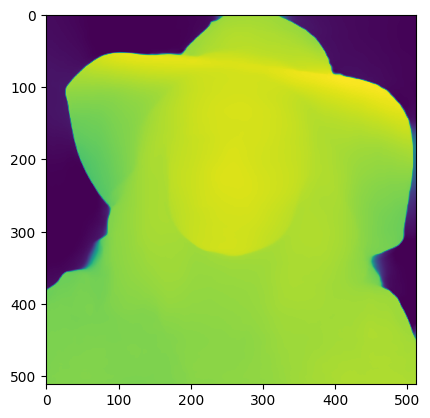

Photo of a young woman wearing a summer dress and a hat, award winning image, photorealistic, 


In [6]:
image_root = '/export/data/ffeiden/PaperControlnetXS/512_images/'
size = 512
reload(glob)

paths = glob.glob(image_root+'*_depth*.png')

instances = []
for im_path in paths: 
    images = {}
    name = im_path.split('/')[-1]
    name, alternative = name.split('_depth')[0], name.split('_depth')[1]
    if '_alt' in alternative: 
        alternative = True
    else: 
        alternative = False
    
    image = cu.get_image(image_root + name + '.png')
    depth = Image.open(im_path)
    if not depth.mode == 'L':
        depth = depth.convert("L") 
    images['original'] = image
    images['depth'] = np.array(depth).astype(np.float32)/255.
    images['Prompt'] = name
    images['alt'] = alternative
    if 'badPrompts' in image_root or 'scales' in image_root:
        if 'cube on' in name: 
            images['insuf_Prompt'] = 'render of a lavender sphere floating in the air'
            images['conflicting_Prompt'] = 'image of a house surrounded by an beautiful garden'
        else: 
            images['insuf_Prompt'] = 'high quality, 4k, detailed, professional work'
            images['conflicting_Prompt'] = 'high quality photo of a delecious cake, 4k image'
    # print(np.min(images['depth']), np.max(images['depth']), images['depth'].shape)
    instances.append(images)

instances = [instances[11]]

plt.imshow(instances[0]['depth'])
plt.show()
# instances[0]['Prompt'] = 'Photo of a young woman wearing a summer dress and a hat, award winning image, photorealistic, '
print(instances[0]['Prompt'])


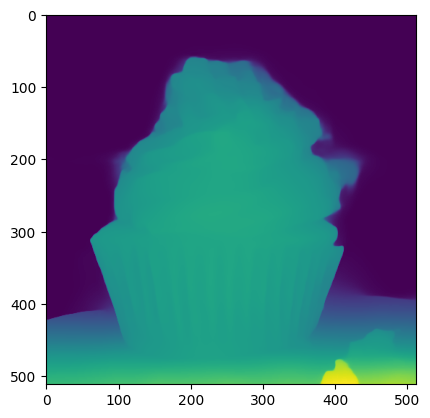

image of a delicious caramel cupcake, high quality, detailed, tasty


In [42]:
size = 512
image_root = '/export/data/dzavadsk/tmp/visualSets/show_images/'#show_images selection  example_samples
#image_root = '/export/data/ffeiden/PaperControlnetXS/Images_test/'
paths = [os.path.join(image_root, path) for path in os.listdir(image_root)]

image_path = paths[4] # 4 woman

canny_high_th = 120
canny_low_th = 100

image = cu.get_image(image_path, size=size)
edges = cu.get_canny_edges(image, low_th=canny_low_th, high_th=canny_high_th)
depth = cu.get_midas_depth(image, max_resolution=size)

it = 0

curr = {}
curr['Prompt'] = 'image of a delicious caramel cupcake, high quality, detailed, tasty'
curr['depth'] = depth
curr['original'] = image
curr['alt'] = False

instances = []
instances.append(curr)

plt.imshow(instances[0]['depth'])
plt.show()
# instances[0]['Prompt'] = 'Photo of a young woman wearing a summer dress and a hat, award winning image, photorealistic, '
print(instances[0]['Prompt'])

In [43]:
### Automate sampling ###
def sample (model, net, subfolder, root):
    
    os.mkdir(root+ net + subfolder)
    os.mkdir(root + net + subfolder + 'AA_grids')


    save = Image.fromarray( (instances[0]['depth']).astype(np.uint8))
    if not save.mode == 'RGB':
        save = save.convert("RGB") 
    save.save(root+net+subfolder+'control.png')
    
    save = image
    if not save.mode == 'RGB':
        save = save.convert("RGB") 
    save.save(root+net+subfolder+'original.png')

    for current in instances:
        for prompt_key in ['Prompt']: #  'insuf_Prompt', 'conflicting_Prompt', 'Prompt'
            for seed in [42,1996, 1995, 1998, 2024]: #   1996, 1998, 2024
                for strength in [1.]:
                    if current['alt']:
                        sampe_name = current['Prompt'] + '_' + prompt_key + '_alt' + '_strength'+str(strength)
                    else: 
                        sampe_name = current['Prompt']+ '_' + prompt_key + '_strength'+str(strength)

                    samples, controls = cu.get_sd_sample(
                        guidance=current['depth'],
                        ddim_steps=50,
                        num_samples=12, #
                        model=model,
                        shape=[4, size // 8, size // 8],
                        control_scale=strength, 
                        prompt=current[prompt_key],
                        seed=seed,
                        n_prompt='',
                    )

                    to_save = Image.fromarray(cu.create_image_grid(samples))
                    to_save.save(root+net+subfolder+'AA_grids/'+sampe_name+'_seed'+str(seed)+'.png')

                    # Generate score 
                    best_depth_score = 999.999
                    best_gen = None
                    best_org_depth = None
                    best_gen_depth = None

                    for i in range(samples.shape[0]):
                        
                        to_save = Image.fromarray(samples[i])
                        to_save.save(root+net+subfolder+sampe_name+'_seed'+str(seed)+'_samp'+str(i)+'.png')
                    


In [45]:
root = '/export/data/ffeiden/ResultsControlNetXS/'
net = 'CNXS/'

for name_net in ['CNXS_1.4', 'CNXS_20', 'CNXS_0.2']: # model_paths: 
    
    model = load_model_from_dic(model_paths[name_net], False, False)
    subfolder = name_net + '_caramel_cupcake/'
    sample(model, net, subfolder, root)

    # model = load_model_from_dic(model_paths[name_net], True, False)
    # subfolder = name_net + '_kitti/'
    # sample(model, net, subfolder, root)

    # model = load_model_from_dic(model_paths[name_net], False, True)
    # subfolder = name_net + '_cubes/'
    # sample(model, net, subfolder, root)

TwoStreamControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280,

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'text_projection.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.23.mlp.fc2.we

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

Global seed set to 42


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
Global seed set to 1996


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
Global seed set to 1995


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
Global seed set to 1998


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
Global seed set to 2024


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


TwoStreamControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280,

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'text_projection.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.23.mlp.fc2.we

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

Global seed set to 42


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]
Global seed set to 1996


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
Global seed set to 1995


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
Global seed set to 1998


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]
Global seed set to 2024


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


TwoStreamControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280,

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'text_projection.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.23.mlp.fc2.we

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

Global seed set to 42


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]
Global seed set to 1996


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
Global seed set to 1995


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
Global seed set to 1998


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]
Global seed set to 2024


Data shape for DDIM sampling is (12, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


# Einzelbilder

In [46]:
model = load_model_from_dic(model_paths['CNXS_20'], False, False)

TwoStreamControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280,

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'text_projection.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.23.mlp.fc2.we

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

In [10]:
size = 512
image_root = '/export/data/ffeiden/PaperControlnetXS/512_images/'
paths = [os.path.join(image_root, path) for path in os.listdir(image_root)]

image_path = '/export/data/ffeiden/PaperControlnetXS/512_images/Photo of a young woman wearing a summer dress and a hat.png'#paths[11]
# '/export/data/ffeiden/PaperControlnetXS/512_images/Photo of a big house with stores at the first floor, cars parked, 4k.png'#

canny_high_th = 120
canny_low_th = 100

image = cu.get_image(image_path, size=size)
edges = cu.get_canny_edges(image, low_th=canny_low_th, high_th=canny_high_th)
depth = cu.get_midas_depth(image, max_resolution=size)

it = 0

In [136]:
size = 768
 #show_images selection  example_samples
# image_root = '/export/data/ffeiden/PaperControlnetXS/Images_test/'
paths = [os.path.join(image_root, path) for path in os.listdir(image_root)]

image_path = paths[5]# 4 woman
canny_high_th = 120
canny_low_th = 100

image = cu.get_image(image_path, size=size)
edges = cu.get_canny_edges(image, low_th=canny_low_th, high_th=canny_high_th)
depth = cu.get_midas_depth(image, max_resolution=size)

it = 0

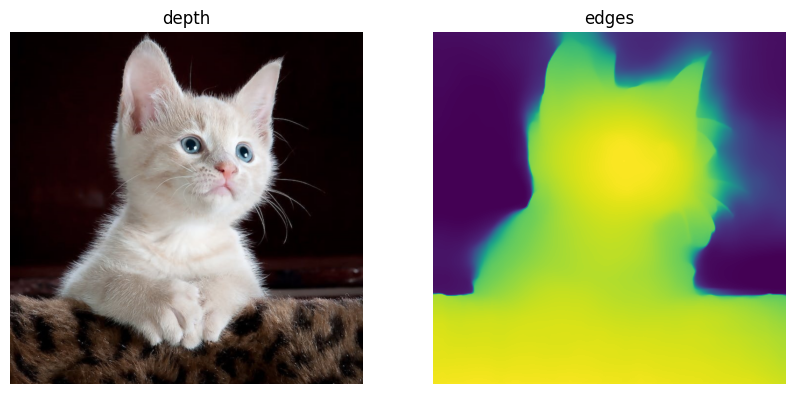

float64 0.0 1.0
872


In [146]:
plt.figure(figsize=(10, 10))


plt.subplot(121)
plt.title('depth')
plt.imshow(image)
plt.axis('off')

plt.subplot(122)
plt.title('edges')
plt.imshow(depth)
plt.axis('off')
plt.show()

print(edges.dtype, np.min(edges), np.max(edges))


#prompt = 'Photo of a big house with stores at the first floor, cars parked, 4k'

prompt = 'high resolution image of a cute white kitten, high quality, award winning image'#'photo of a beautiful young woman, award winning picture, professional photo, black and white'
n_prompt = 'drawing, long hands, bad quality, standart quality, low resolution'

seed = np.random.randint(4_000)
#seed = 2636
print(seed)

[CONTROL CORRECTION OF TwoStreamControlLDM SCALED WITH 0.9]


Global seed set to 872


Data shape for DDIM sampling is (4, 4, 96, 96), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


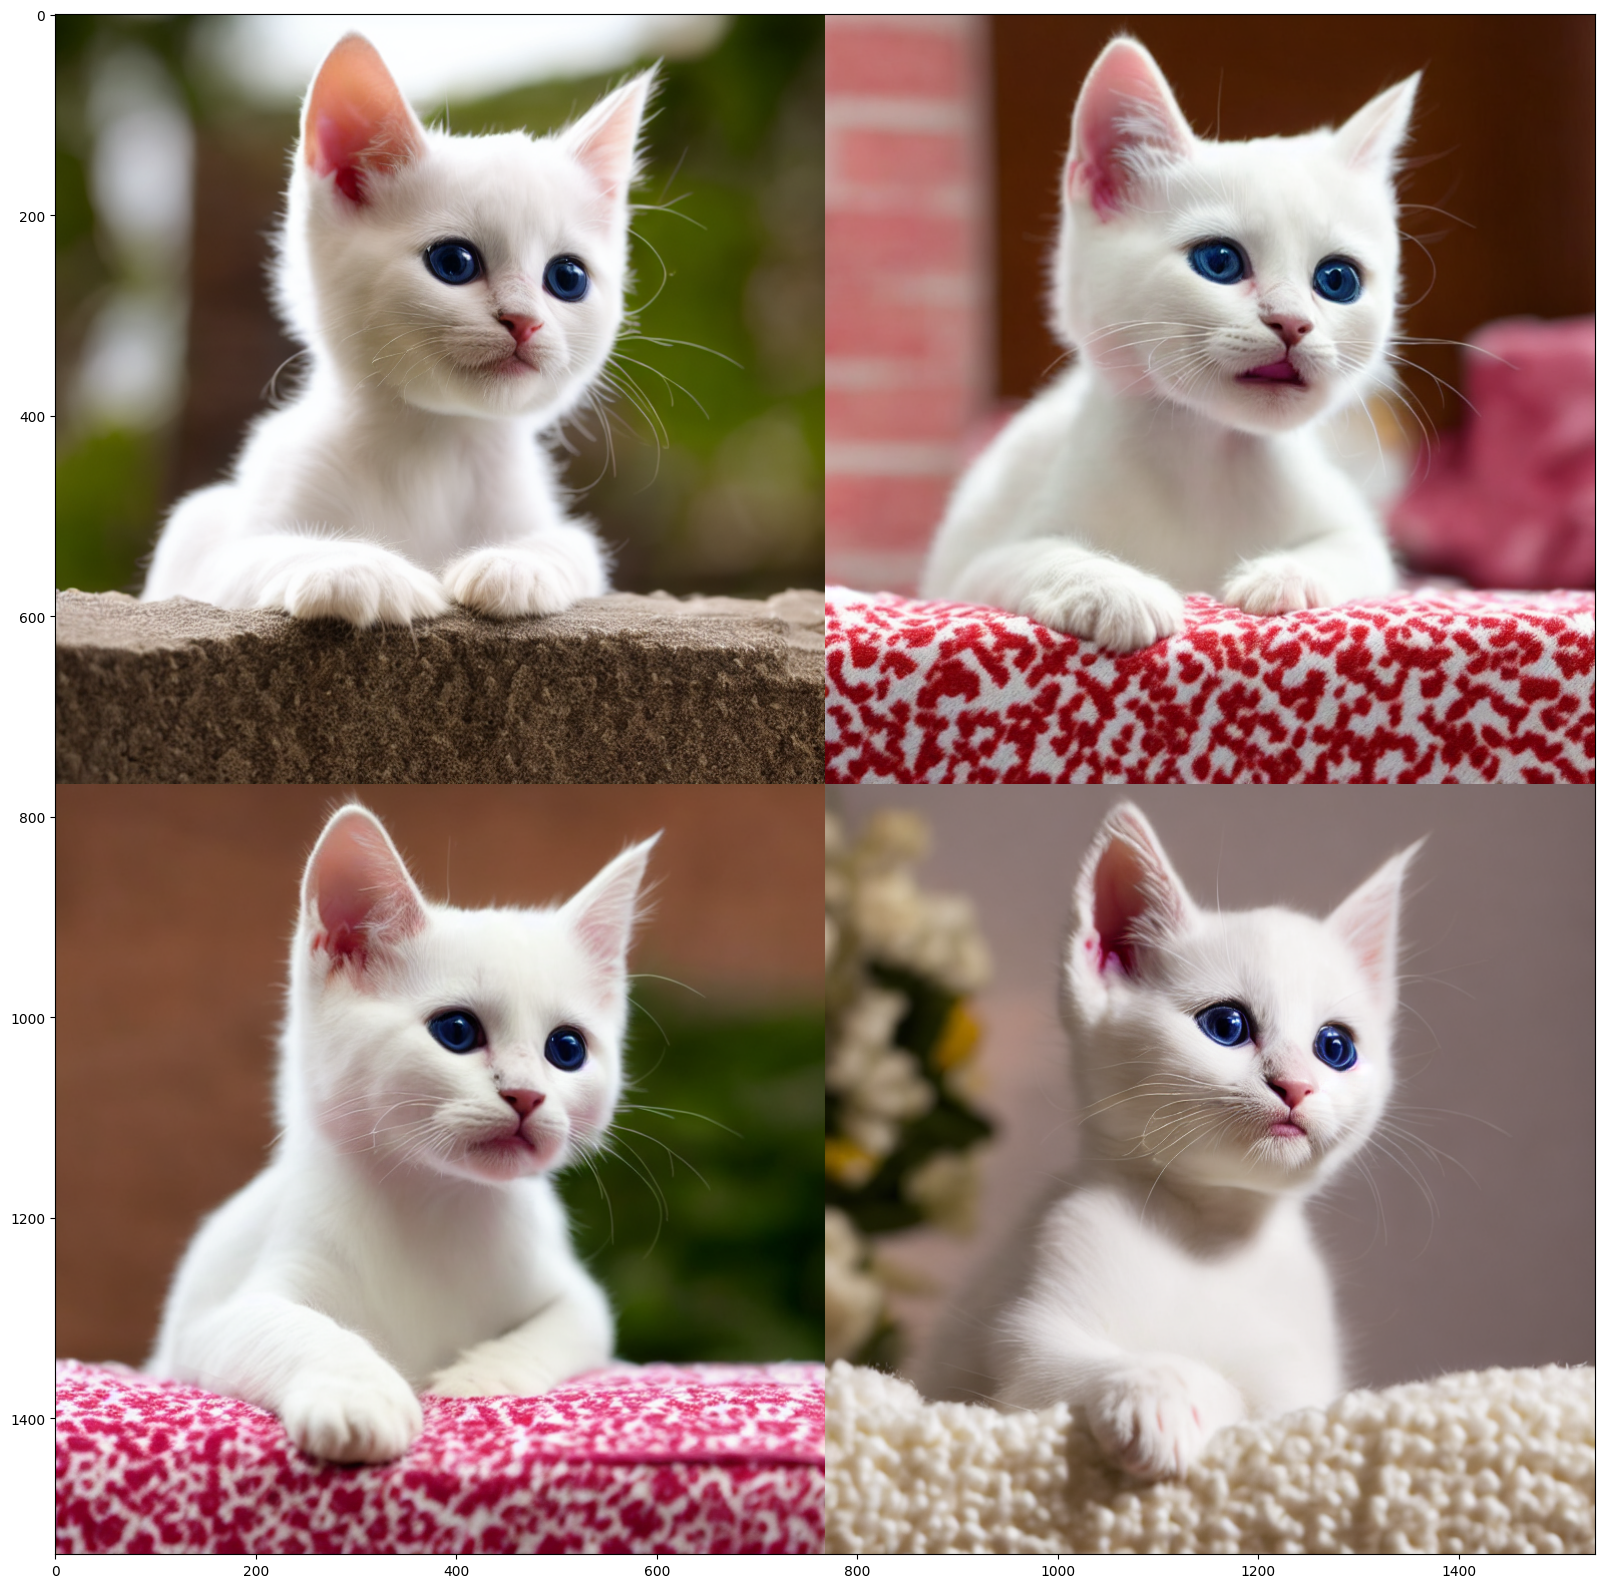

In [147]:
samples, controls = cu.get_sd_sample(
    guidance=depth,
    ddim_steps=50,
    num_samples=4,
    model=model,
    shape=[4, size // 8, size // 8],
    control_scale=0.9, # currently not working
    prompt=prompt,
    n_prompt=n_prompt,
    seed=seed,
)
plt.figure(figsize=(20, 20))
plt.imshow(cu.create_image_grid(samples))

# to_save = Image.fromarray(cu.create_image_grid(samples))
# to_save.save('/export/data/ffeiden/PaperControlnetXS/'+net+sampe_name+'_grid_seed'+str(seed)+'.png')

In [ ]:

sampe_name = prompt + '_it'+str(it)+'_seed'+str(seed)
good = samples[3]


plt.imshow(good)
plt.show()

to_save = Image.fromarray(good)
if it == 0: 

    save = Image.fromarray( (depth * 255).astype(np.uint8))
    if not save.mode == 'RGB':
        save = save.convert("RGB") 
    save.save('/export/data/ffeiden/ResultsControlNetXS/Cheery_good/'+sampe_name+'_control.png')
to_save.save('/export/data/ffeiden/ResultsControlNetXS/Cheery_good/'+sampe_name+'.png')
it +=1

In [20]:
prompt = 'high quality photo of a beautiful, blonde woman with braided hair, wearing an elegant dress. Good Quality, fashion design, photography award, soft sunlight filtered throught trees, park in background'
n_prompt = 'blurry, bad quality, long hands, glasses, painting, drawing, black and white, oil painting, cartoon, normal quality, distorted, deformed'

prompt = 'high quality image of a beautiful, blonde woman with braided hair wearing leather armor. Good Quality, fashion design, soft sunlight filtered throught trees, highly detailed render'
n_prompt = 'blurry, bad quality, bad eyes, long hands, glasses, painting, drawing, black and white, oil painting, cartoon, normal quality, distorted, deformed'

prompt = 'high quality image of a beautiful, blonde woman with braided hair. Good Quality, fashion design, fire and smoke in the background, highly detailed render'
n_prompt = 'blurry, bad quality, bad eyes, long hands, glasses, painting, drawing, black and white, oil painting, cartoon, normal quality, distorted, deformed, sexualised'



1.0

In [16]:
size = 1024
image_root = '/export/data/dzavadsk/tmp/visualSets/show_images/'
paths = [os.path.join(image_root, path) for path in os.listdir(image_root)]

image_path = paths[0]

canny_high_th = 120
canny_low_th = 100

image = cu.get_image(image_path, size=size)
edges = cu.get_canny_edges(image, low_th=canny_low_th, high_th=canny_high_th)
depth = cu.get_midas_depth(image, max_resolution=size)


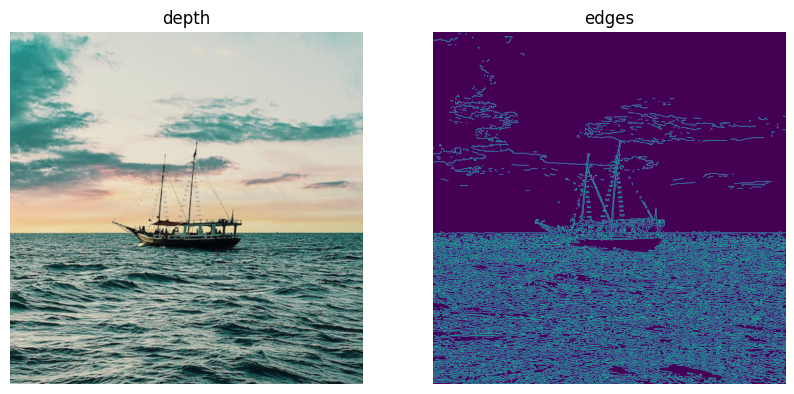

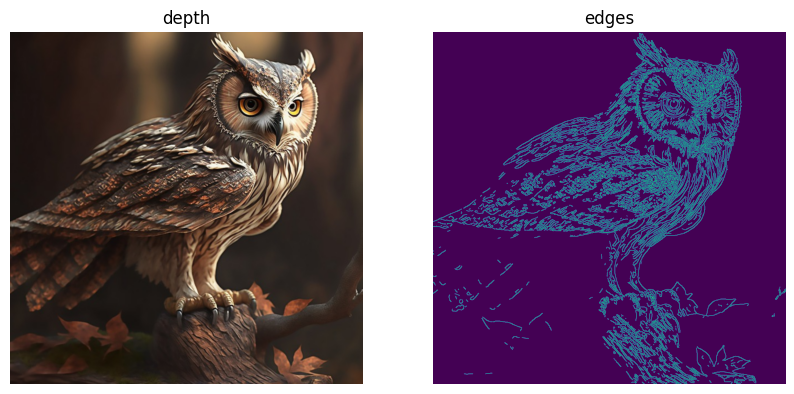

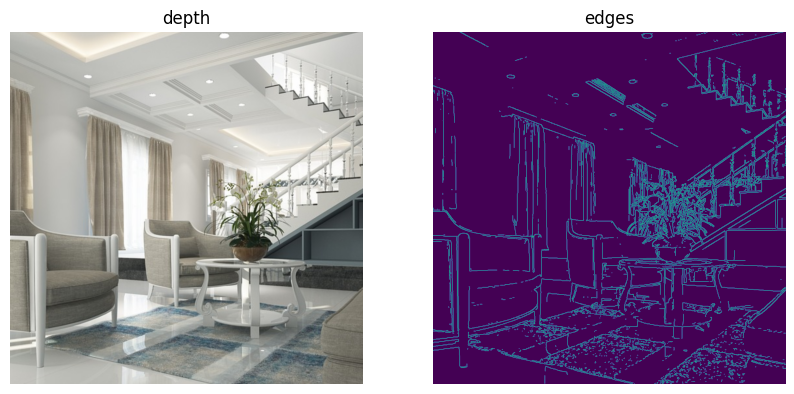

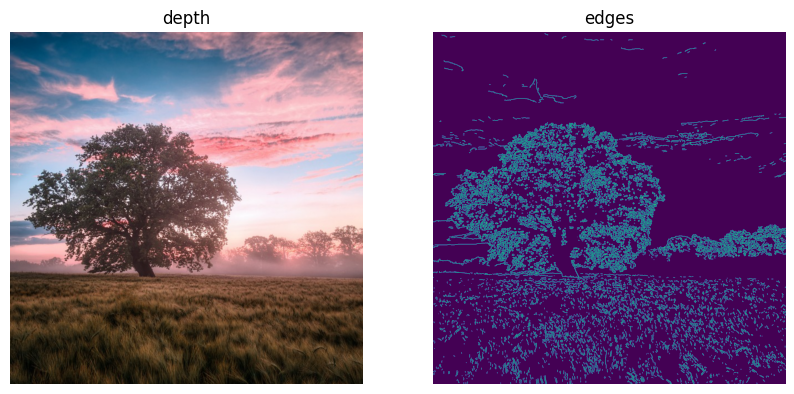

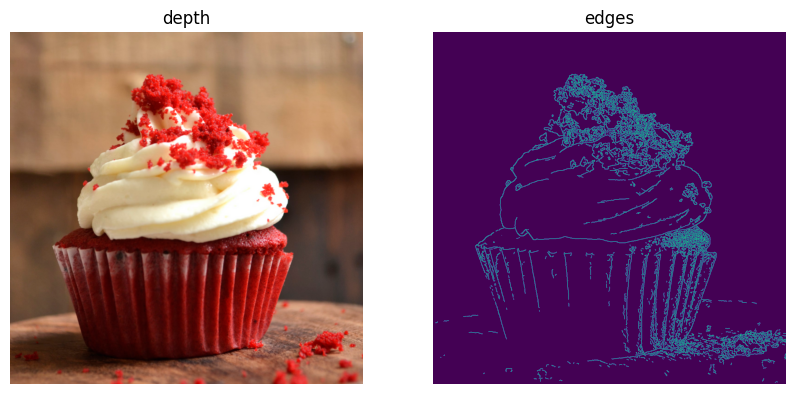

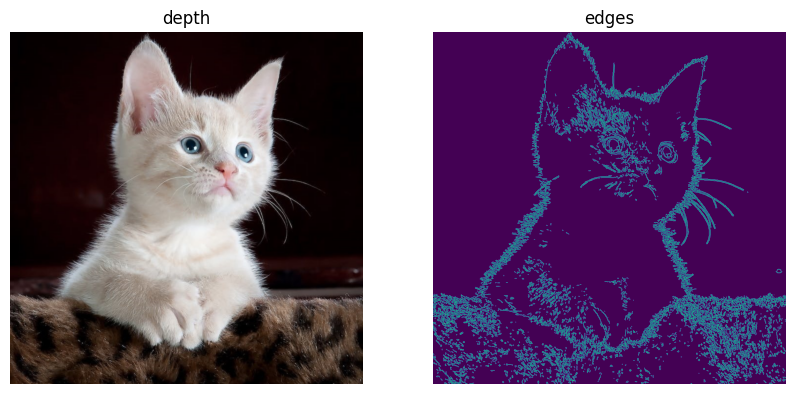

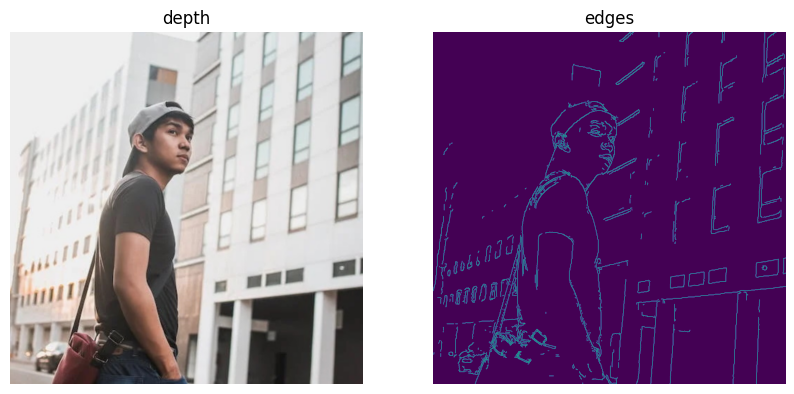

In [17]:
for i in range(len(paths)):
    image_path = paths[i]

    canny_high_th = 120
    canny_low_th = 100

    image = cu.get_image(image_path, size=size)
    edges = cu.get_canny_edges(image, low_th=canny_low_th, high_th=canny_high_th)
    depth = cu.get_midas_depth(image, max_resolution=size)

    plt.figure(figsize=(10, 10))


    plt.subplot(121)
    plt.title('depth')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(122)
    plt.title('edges')
    plt.imshow(edges)
    plt.axis('off')
    plt.show()

    name = image_path.split('/')[-1]
    name = name.split('.jpg')[0]

    save = Image.fromarray( (edges * 255).astype(np.uint8))
    if not save.mode == 'RGB':
        save = save.convert("RGB") 
    save.save('/export/data/ffeiden/ResultsControlNetXS/CNXS_SDXL/MoneyPlots/'+name+'_canny.png')

    save = Image.fromarray( depth.astype(np.uint8))
    if not save.mode == 'RGB':
        save = save.convert("RGB") 
    save.save('/export/data/ffeiden/ResultsControlNetXS/CNXS_SDXL/MoneyPlots/'+name+'_depth.png')

    save = image
    if not save.mode == 'RGB':
        save = save.convert("RGB") 
    save.save('/export/data/ffeiden/ResultsControlNetXS/CNXS_SDXL/MoneyPlots/'+name+'_image.png')

